# How to Plot a Confusion Matrix from a K-Fold Cross-Validation

## How to plot a combined confusion matrix for all of the folds involved in a k-fold cross- validation evaluation of a classification machine learning algorithm

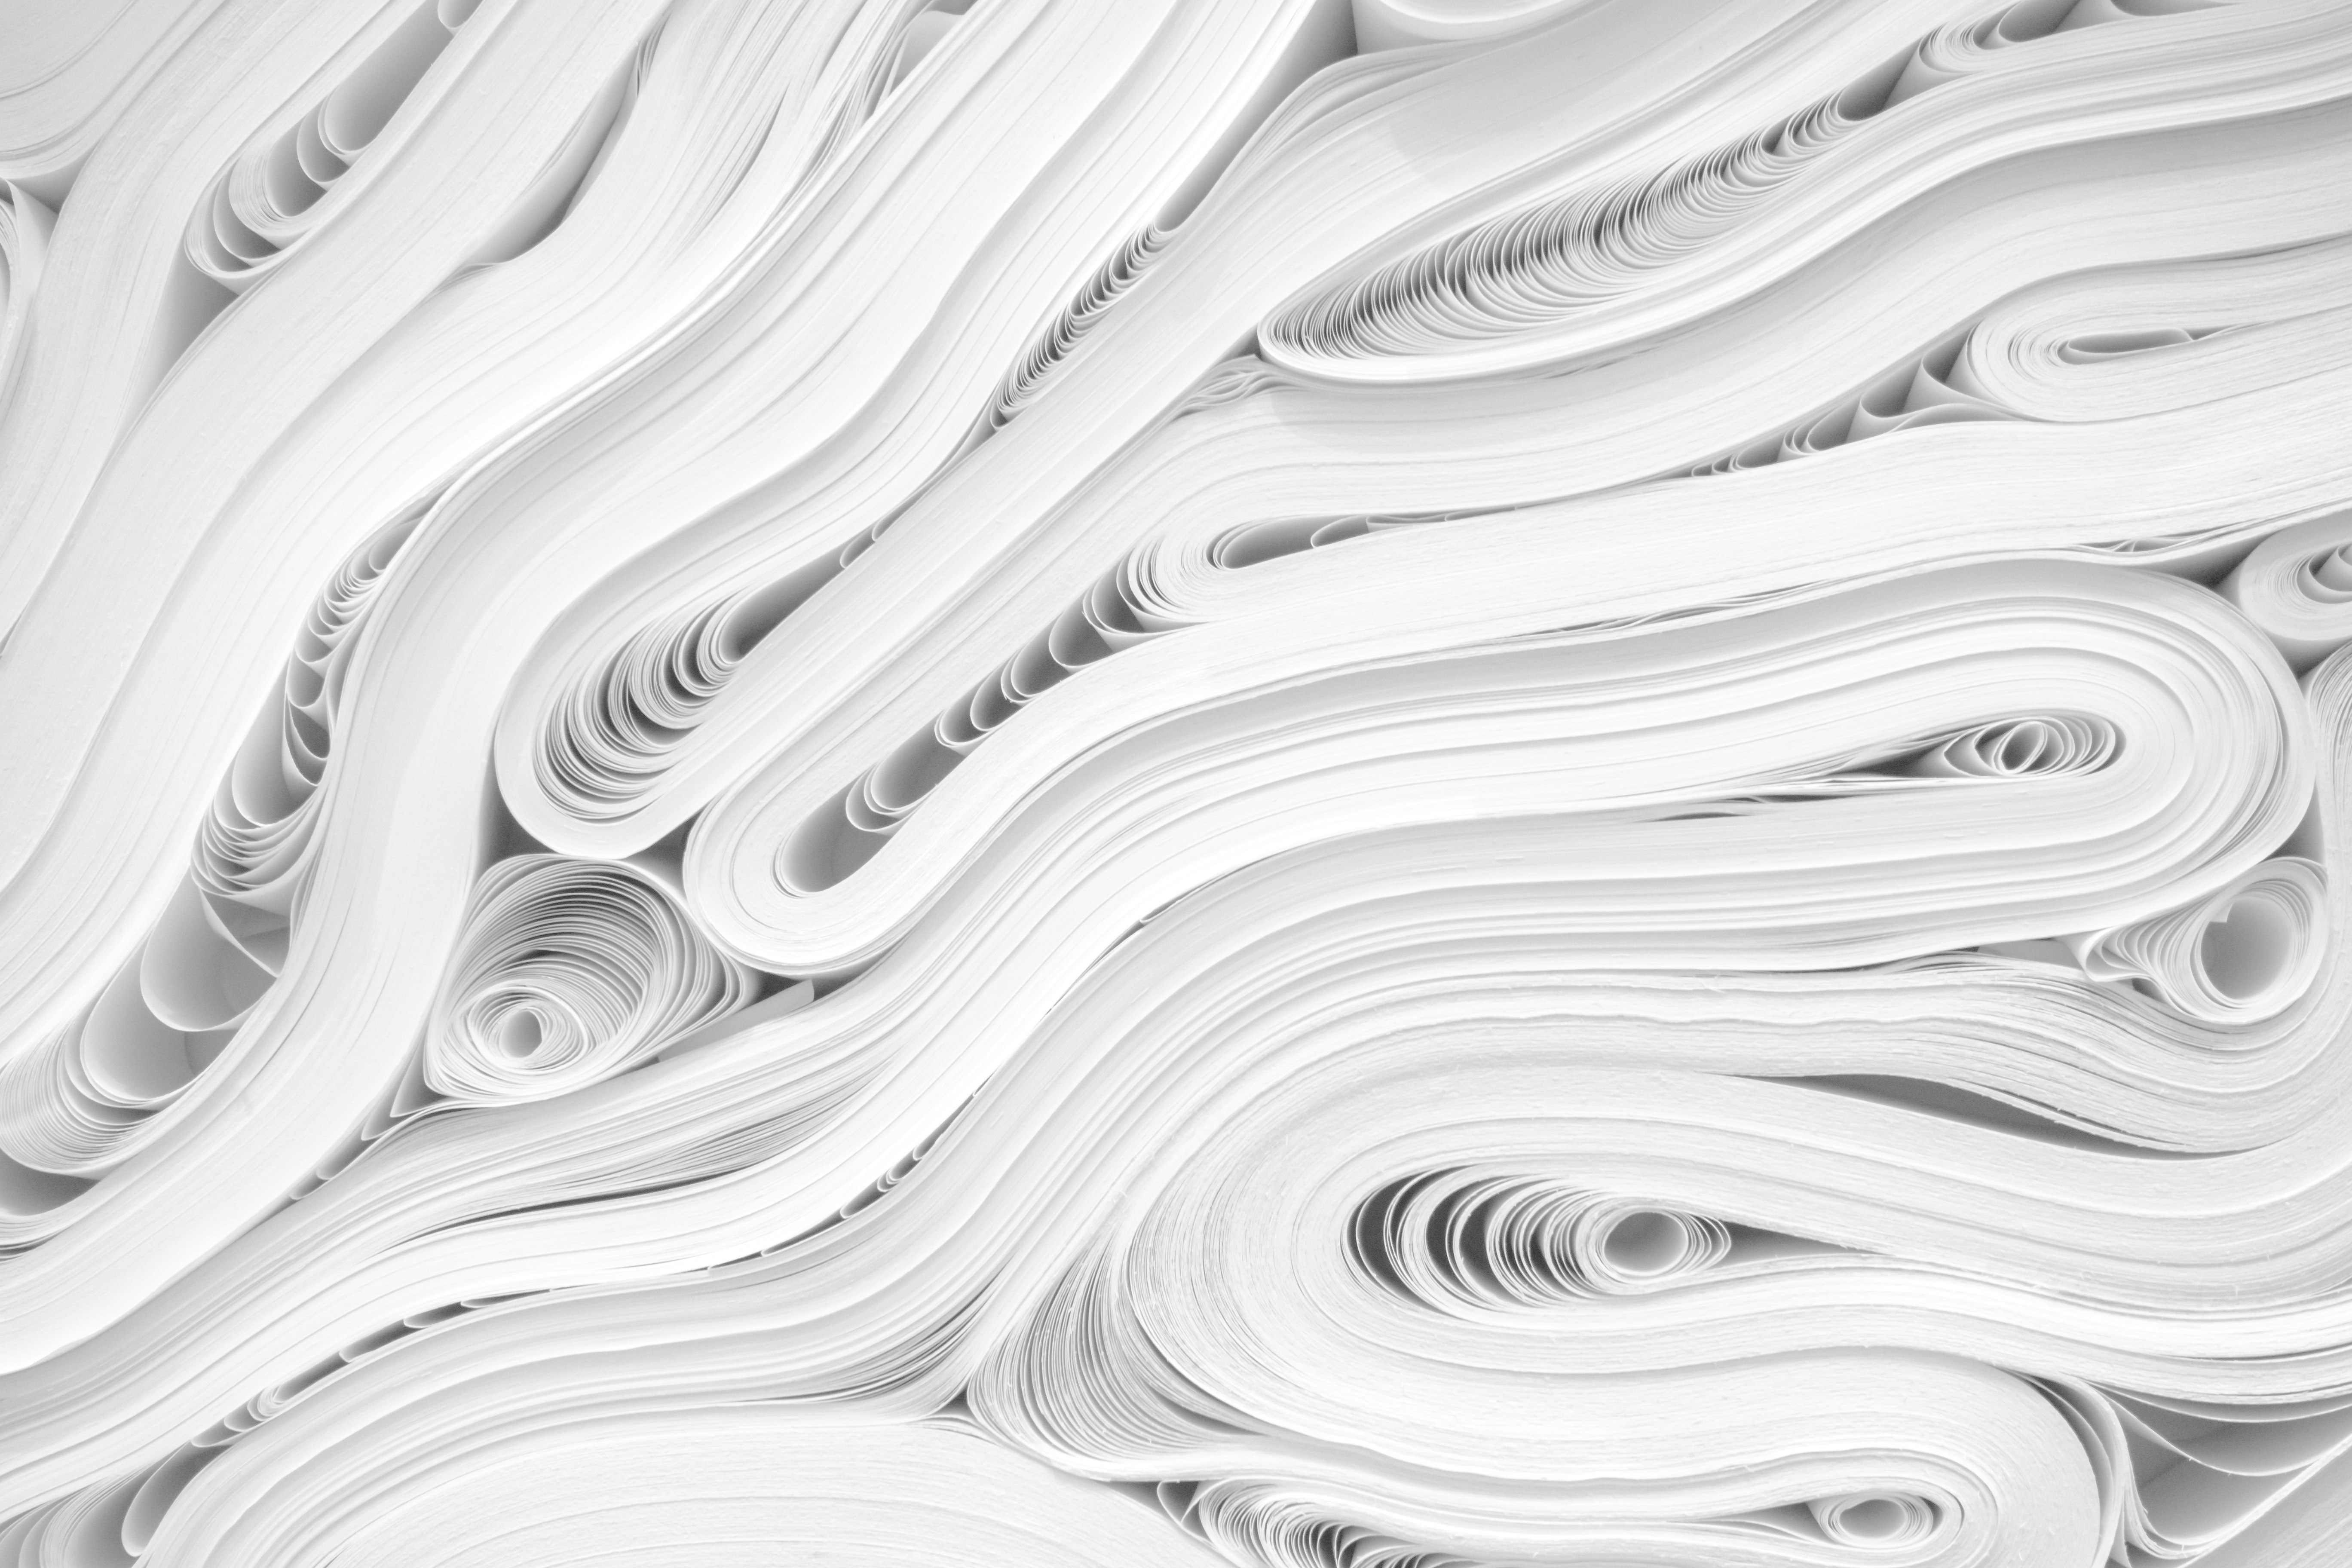
Photo by <a href="https://unsplash.com/@jjying?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">JJ Ying</a> on <a href="https://unsplash.com/s/photos/fold?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Background
When a machine learning model is evaluated for performance it is common to divide the data up into a training set and a test set, for example by sampling 80% of the data for training and 20% for testing.

The model is fitted to the training data and can then be evaluated and tuned using a range of metrics including accuracy, precision, recall, f1 score etc.

Eventually the machine learning model will be performance evaluated against the test data that was put on one side and excluded from the training as evaluating against new data that were not used in the model building process gives a better indication of how these models will perform in the real world.

However, there can sometimes be issues with this approach. In Kaggle competitions I have entered I have often been euphoric that my latest algorithm performs so well against my reserved test data only to try it out against the Kaggle validation data to find that performance is poor.

So what is going on here? Well, after much head scratching and failing to climb the leader board in those Kaggle competitions I concluded that I had just got lucky with the sample selected for the test data and scored highly for performance.

This is where k-fold cross-validation comes in.

Instead of sampling 20% of the data for testing and leaving the remaining 80% for training, cross-validation has several goes at sampling the data sampling a different set of data for testing and training each time. It can be visualised as follows -



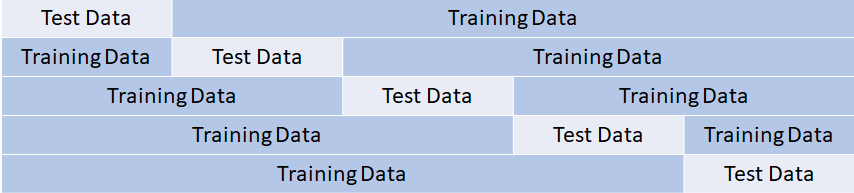
Image by Author

To note: in reality the folds are not as neat and clean as this. The image above givesd the impression that the training data and test data is all contiguous (i.e. the rows are immediately next to each other) which is not what actually happens.

Inside the ``scikit-learn`` library the set of rows that I have visualised in the first block of "Test Data" have actually been sampled from all over the full data set but for the purposes of learning how cross-validation works the simplified visual is much easier to understand.

This data has been split into 5 "fold" which can be achieved in Python using the ``scikit-learn`` library as follows -

In [1]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

df_reviews = pd.read_excel("https://github.com/grahamharrison68/Public-Github/blob/master/Analyzing%20Customer%20Feedback/data/out/Womens%20Clothing%20E-Commerce%20Reviews%20with%20Emotions.xlsx?raw=true")
    
df_reviews.dropna(inplace=True) 
df_reviews.reset_index(drop=True, inplace=True)

X = df_reviews.loc[:,['Review Rating', 'Review Positive Feedback Count']]
y = df_reviews['Review Sentiment']

model = RandomForestClassifier(random_state=42)
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy', verbose=10)

print(cv_results.mean(), cv_results.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................... , score=0.929, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.920, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.909, total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... , score=0.903, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.891, total=   0.1s
0.9104240944240944 0.013065158449965447


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Please note: I have chosen a dataset from Kaggle (https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews) that is licensed under the "CC0: Public Domain" license which means that "you can copy, modify, distribute and perform the work, even for commercial purposes, all without asking permission" (see https://creativecommons.org/publicdomain/zero/1.0/) for details.

Note: any GitHub file can be referenced directly in a Jupyter Notebook or any other Python or non-Python environment simply by suffixing the URL of the file within the GitHub repository with ``?raw=true``, for example ...

https://github.com/grahamharrison68/Public-Github/blob/master/Analyzing%20Customer%20Feedback/data/out/Womens%20Clothing%20E-Commerce%20Reviews%20with%20Emotions.xlsx?raw=true

The call to ``KFold`` create 5 "folds" of data divided into training and test sets and the call to ``cross_val_score`` does the following -

1. Iterates over each of the 5 folds
2. For each fold, fits the model to the 4/5 ths of data reserved for training
3. Evaluates the performance of the model against the 1/5 th of the data reserved for testing

The call to ``cv_results.mean()`` calculates the mean of the performance over all 5 folds which as a single number is much more likely to give an indication of production performance than ignoring cross-validation in favour of a single training / test split.

### The Problem
One issue I have found with cross-validation is that I like to plot a confusion matrix for my classification machine learning algorithms to help me visualise the performance and there is no direct and immediate way to do this.

If I had executed a single training / test split I would have fitted the model to the training data and I could then use the model to predict the classes of the test data and pass these together with the actual classes into the confusion matrix.

However, when using cross-validation the model fitting has taken place inside ``cross_val_score``. Our ``model`` instance of the ``RandomForestClassifier`` has not been fitted and even if it had, exactly what data should be used to evaluate it against?

It turns out that there is a relatively straightforward way to produce a set of predicted and actual classes that can then be used in a confusion matrix to visualise the performance and effectiveness of the algorithm.

#### 1. Import Libraries
There are a few more libraries that are required to complete this task ...

In [2]:
import numpy as np
import copy as cp
import matplotlib.pyplot as plt

import seaborn as sns
from typing import Tuple
from sklearn.metrics import confusion_matrix

#### 2. Calculate the Predicted and Actual Classes

In [3]:
def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = cp.deepcopy(model)
    
    actual_classes = np.array([])
    predicted_classes = np.array([])

    splits = kfold.split(X)
    
    for train_ndx, test_ndx in splits:

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

    return actual_classes, predicted_classes

The core part of the solution is to calculate the actual and predicted classes (i.e. classifications) for the folded data by defining a helper function called ``cross_val_predict`` that does the following -

1. Takes a local copy of the machine learning algorithm (``model``) to avoid changing the one passed in
2. Iterates around the 5 cross-validation data folds (given that ``n_splits=5``).
3. For each of the 5 splits -
    3.1. Extracts the rows from the data for the training features, training target, test features and test target
    3.2. Appends the actual target classifications to ``actual_classes``
    3.3. Fits the machine learning model using the training data extracted from the current fold
    3.4. Uses the fitted model to predict the target classifications for the test data in the current fold
    3.5. Appends the predicted classes for the current fold of test data to ``predicted_classes``
    
The helper function then returns a set of actual and predicted classes (classifications) that can be used to plot a confusion matrix.

#### 3. Visualise the Confusion Matrix

In [4]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

The ``plot_confusion_matrix`` helper function uses ``sklearn.metrix.confusion_matrix`` to calculate the matrix followed by a seaborn ``heatmap`` to show it in a nice format that helps to fully understand the performance of the algorithm through visualisation.

#### 4. Call the Helper Functions
With the two helper functions defined it just remains to call them sequentially to calculate the actual and precited classes and then to display the confusion matrix ...

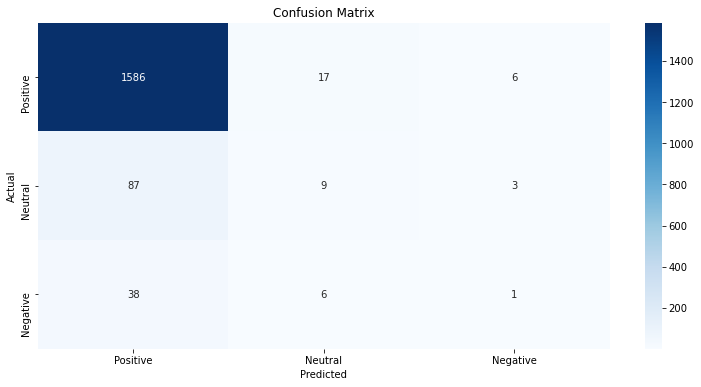

In [5]:
actual_classes, predicted_classes = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, ["Positive", "Neutral", "Negative"])

The overall cross-validation accuracy figure of 91% looked like good performance but the visualisation of the compound confusion matrix shows that whilst the algorithm is good at predicting when ``Review Sentiment`` is ``Positive`` it is much worse at predicting ``Neutral`` and ``Negative`` classifications.

### Conclusion
Abhisek Thakur who is a Data Scientist and the world's first Kaggle quadruple grand master defines cross-validation as 


<i><center>"a step in the process of building a machine learning model which helps us ensure that our models fit the data accurately and also ensures that we do not overfit"</center></i>

He goes on to say ...

<i><center>"Cross-validation is the first and most essential step when it comes to building machine learning models. If you have a good cross-validation scheme in which validation data is representative of training and real-world data, you will be able to build a good machine learning model which is highly generalizable."</center></i>

This strong recommendation from a world-leading data scientist leads to the conclusion that k-fold cross-validation is a better approach that a simple training / test split, hence this article set out to explain cross-validation by visualising it and providing examples.

It was noted that one drawback of cross-validation using ``cross_val_score`` in the ``scikit-learn`` library is that there is no direct way to visualise the results in a confusion matrix and the data used in the example showed how useful a confusion matrix can be, especially if the data is imbalanced.

The article then provided the code and an explanation for a helper functon called ``cross_val_predict`` that solves this problem by accessing the indicies of the folds and building the actual and predicted classes before visualising the results effectively in a confuction matrix using the ``plot_confusion_matrix`` function.

K-fold cross-validation is a core step in the process building of accurate machine learning algorithms and extracting and visualising the actual and predicted classifications can be very useful in understanding the results and optimising performance.

### Thank you for reading!
If you enjoyed reading this article, why not check out my other articles at https://grahamharrison-86487.medium.com/? Also, I would love to hear from you to get your thoughts on this piece, any of my other articles or anything else related to data science and data analytics.

If you would like to get in touch to discuss any of these topics please look me up on LinkedIn — https://www.linkedin.com/in/grahamharrison1 or feel free to e-mail me at GHarrison@lincolncollege.ac.uk.

If you would like to support the author and 1000’s of others who contribute to article writing world-wide by subscribing, please use this link — https://grahamharrison-86487.medium.com/membership (note: the author will receive a proportion of the fees if you sign up using this link).